## Planky

Problem: Draw a bounding polygon around a point cloud<br>
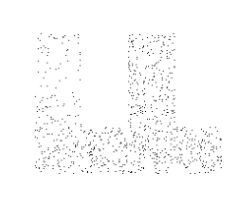

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from time import time
import alphashape
from shapely.geometry.polygon import Polygon

In [3]:
def angle_to(x, y):
    if x>0:
        a = np.arctan(y/x)
    elif x<0:
        a = np.pi + np.arctan(y/x)
    elif y>0:
        a = np.pi/2
    else:
        a = -np.pi/2
    if a<0:
        a += 2*np.pi
    return a

def next_start_angle(x,y):
    """
    Starting from (x0, y0), we move to (x1,y1).
    From this new point, we want to start the sweep
    45 degrees past the direction we came from so as not
    to include the previous location unless it is the only
    option.
    """
    a = angle_to(x, y) + 3*np.pi/4
    if a<0:
        a += 2*np.pi
    return a

def shift(i,j,k):
    x = i - k
    y = k - j
    return x,y

def sweep_kernel(length: int, angle:float=0):
    """
    Generates a kernel to simulate a sweeping action
    in which a plank starts at a certain angle wrt the positive
    x axis and rotates clockwise 360 degrees
    """
    d = (2*length)+1
    kernel = np.zeros((d, d))
    dist = np.zeros((d, d))
    for y in range(length, -length-1, -1):
        for x in range(-length, length+1, 1):
            i = length - y
            j = x - length - 1
            kernel[i,j] = angle_to(x,y)
            dist[i,j] = x**2+y**2
    dist_mask=dist>length**2
    dist_mask[length,length] = 1
    kernel -= angle
    kernel[kernel>2*np.pi] -= 2*np.pi
    kernel[kernel<0] += 2*np.pi
    kernel[dist_mask] = 0
    return kernel, dist_mask
    
def rotate(kernel, dist_mask, angle):
    length = (kernel.shape[0]-1)//2
    kernel -= angle
    kernel[kernel>2*np.pi] -= 2*np.pi
    kernel[kernel<0] += 2*np.pi
    kernel[dist_mask] = 0
    

In [4]:
k,m = sweep_kernel(25)

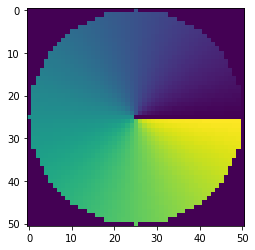

In [5]:
plt.imshow(k)

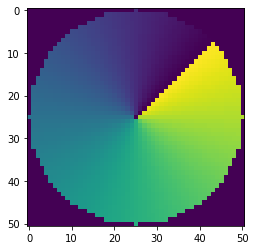

In [6]:
rotate(k,m,np.pi/4)
plt.imshow(k)

In [7]:
grid = np.zeros((1000,1000))
grid[500:700, 100:900] = np.random.rand(200, 800)>0.95
grid[100:600, 100:300] = np.random.rand(500, 200)>0.97
grid[100:600, 500:700] = np.random.rand(500, 200)>0.95
points = list(zip(*np.where(grid==1)))

In [8]:
grid = np.zeros((300,300))
grid[150:200, 50:250] = np.random.rand(50, 200)>0.95
grid[50:150, 50:100] = np.random.rand(100, 50)>0.97
grid[50:150, 150:200] = np.random.rand(100, 50)>0.95
points = list(zip(*np.where(grid==1)))

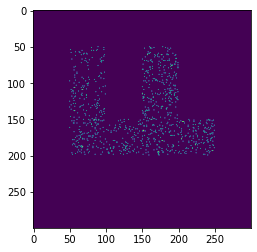

In [9]:
plt.imshow(grid)

In [10]:
len(points)

896

In [11]:
def planky(points, d=10):
    points = np.array(points)
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    
    points -= [xmin, ymin]
    points += d+1
    
    grid = np.zeros(
        (
            xmax-xmin+d*2+2,
            ymax-ymin+d*2+2
        )
    )
    visited = grid.copy()
    
    grid[tuple(points.T)] = 1

    i = points.argmin(axis=0)[1]
    first = tuple(points[i])
    y, x = first
    dy, dx = 0,1

    kernel, dist_mask = sweep_kernel(d)
    current_angle = 0

    polygon = []
    N = len(points)
    N_root = N**0.5
    n = 0
    h = 0
    while True:
        h += visited[y,x]
        n += 1
        polygon.append((y,x))
        visited[y,x]=1

        vision = grid[y-d:y+d+1, x-d:x+d+1]
        new_angle = next_start_angle(dx,dy)
        rotate(kernel, dist_mask, new_angle - current_angle)
        current_angle = new_angle
        
        m = kernel * vision
        i = m.max(axis=1).argmax()
        j = m[i].argmax()
        
        dy = d-i
        dx = j-d
        
        x+=dx 
        y-=dy
        
        if m[i,j]<=0 or h > 30 or n > N: return
        if (y,x) == first:
            if n < N_root: return
            return polygon

In [12]:
grid = np.zeros((1000,1000))
grid[500:700, 100:900] = np.random.rand(200, 800)>0.98
grid[100:600, 100:300] = np.random.rand(500, 200)>0.99
grid[100:600, 500:700] = np.random.rand(500, 200)>0.95
points = list(zip(*np.where(grid==1)))
# plt.imshow(grid)

planky done in 0.23995566368103027


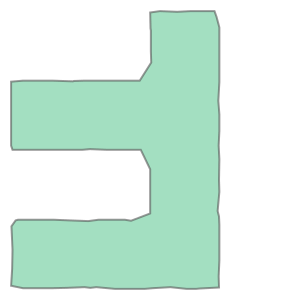

In [13]:
t0 = time()
for i in range(60,70):
    poly = planky(points, i)
    if poly is not None:
        poly = Polygon(poly)
        break
print(f"planky done in {time()-t0}")
poly

alphashape done in 1.8179945945739746


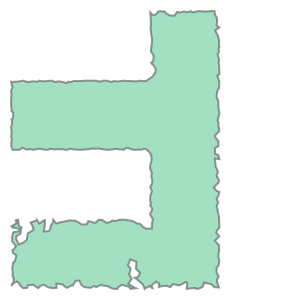

In [14]:
t0 = time()
a = alphashape.alphashape(points, 0.1)
print(f"alphashape done in {time()-t0}")
a